# Goodreads Book Ratings Prediction 

## Introduction 

This project involves the use of book features from the goodreads datasets to predict the average rating of a book. The average rating of a book ranges from 1 to 5. Several features from the books datasets and generated features have been explored to carry out a classification task


## Data Preprocessing

The section below covers getting the datasets and performing data cleaning to prepare the data in the right format for exploratory data analysis. The section ends with splitting the clean data into the training and test datasets

### Load Relevant Datasets & Libraries

In [1]:
# Load relevant libraries
import pandas as pd
import plotly
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pickle

In [2]:
sns.set(color_codes=True)

In [3]:
pd.set_option('display.max_rows',None)
import warnings
warnings.filterwarnings('ignore')

In [4]:
# set base path to datasets folder
dir_path = '../data/raw/'

# Load raw books dataset 
df_raw_books = pd.read_csv(dir_path + 'books.csv', header =0)
# Make a copy of df_raw_books
df_books = df_raw_books.copy(deep=True)

# Load raw books dataset 
df_raw_ratings = pd.read_csv(dir_path + 'ratings.csv',header = 0)
# Make a copy of df_raw_ratings
df_ratings = df_raw_ratings.copy(deep=True)

# Load raw books dataset 
df_raw_booktags = pd.read_csv(dir_path + 'book_tags.csv',header =0)
# Make a copy of df_raw_booktags
df_booktags = df_raw_booktags.copy(deep=True)

# Load raw books dataset 
raw_to_read_data = pd.read_csv(dir_path + 'to_read.csv',header=0)
# Make a copy of raw_to_read_data
to_read_data = raw_to_read_data.copy(deep=True)

# Load raw books dataset 
raw_tags = pd.read_csv(dir_path + 'tags.csv',header=0)
# Make a copy of raw_tags
tags = raw_tags.copy(deep=True)

In [5]:
# Print the dimension of df_ratings
pd.DataFrame([[df_ratings.shape[0], df_ratings.shape[1]]], columns=['# rows', '# columns'])

# rows  # columns
0  981756          3

In [6]:
# Print the dimension of df_booktags
pd.DataFrame([[df_booktags.shape[0], df_booktags.shape[1]]], columns=['# rows', '# columns'])

# rows  # columns
0  999912          3

In [7]:
# Print the first 5 rows of df_booktags
df_booktags.head()

book_id  tag_id   count
0        1   30574  167697
1        1   11305   37174
2        1   11557   34173
3        1    8717   12986
4        1   33114   12716

In [8]:
type(df_booktags)

pandas.core.frame.DataFrame

In [9]:
# Print the first 5 rows of df_ratings
df_ratings.head()

book_id  user_id  rating
0        1      314       5
1        1      439       3
2        1      588       5
3        1     1169       4
4        1     1185       4

In [10]:
# Display shapes from all datasets
print(df_books.shape)
print(df_ratings.shape)
print(df_booktags.shape)
print(to_read_data.shape)
print(tags.shape)

(10000, 23)
(981756, 3)
(999912, 3)
(912705, 2)
(34252, 2)


### Data Cleaning

In this sub-section, we look through each of the imported datasets and perform necessary cleaning operations. 

#### Clean Ratings Dataset

The total number of observation for the ratings datasets is approximately 1 million which is large. For the purpose of this project, we obtain a subsample of the ratings for use in our analysis.

In [11]:
# sort rating dataset by user_id and book_id
df_ratings = df_ratings.sort_values(by=['user_id','book_id'])

# construct key using combination of book_id and user_id
df_ratings['key']=df_ratings.book_id.astype(str)+df_ratings.user_id.astype(str)

# deduping ratings
df_ratings = df_ratings.drop_duplicates('key',keep='first')

df_ratings.shape

(979310, 4)

In [12]:
# create new column to store user count
df_ratings['user_count']= df_ratings.groupby(['user_id'])['book_id'].transform('count')

# filter user count greater than two
df_ratings = df_ratings.loc[df_ratings['user_count']>2]

In [13]:
# create a subsample of users for our analysis
users = df_ratings['user_id'].unique()
sample_users = users[0:9500]

df_ratings_samp = df_ratings.loc[df_ratings['user_id'].isin(sample_users)]

df_ratings_samp.shape

(214231, 5)

In [14]:
df_ratings_samp.set_index(["rating",'user_id']).count(level="rating")

book_id    key  user_count
rating                            
1          4138   4138        4138
2         16929  16929       16929
3         63925  63925       63925
4         80887  80887       80887
5         48352  48352       48352

##### Clean Tags Dataset

The tags datasets contain tags like 'to-read','fantasy','thriller' etc which can be useful for predicting book ratings. The tags data contains tags/shelves/genres assigned by users to books. Tags in this file are represented by their IDs. The orginal file had the tag_name column which contained a lot of garbage values and special characters along with the tag name in english. We used Regex to extract the english tag, creating a new column called 'tag_cleaned'. We peek into the datasets and clean tags in a format ready for analysis

In [15]:
#extracting tags from the tag name column
tags['tag_cleaned']=tags['tag_name'].str.extract(r"([a-z].*)", expand=False)

# print first five rows of tags dataset
tags.head()

tag_id tag_name tag_cleaned
0       0        -         NaN
1       1     --1-         NaN
2       2    --10-         NaN
3       3    --12-         NaN
4       4   --122-         NaN

In [16]:
# merge extracted tags with the booktags dataset containing tag ids only, to get the actual tag in words
tags_data = pd.merge(df_booktags, tags, how='left', on='tag_id')

# print the shape of the merge tag dataset
tags_data.shape

(999912, 5)

In [17]:
# pick relevant columns from tags data
tags_data = tags_data[['book_id','count','tag_id','tag_cleaned']]

In [18]:
# selecting the tag with highest count of tags for each book
td = tags_data.sort_values(by=['book_id','count'],ascending=[1,0]).groupby('book_id').head(1)

td.head(10)

book_id   count  tag_id tag_cleaned
0          1  167697   30574     to-read
100        2   24549   30574     to-read
200        3  496107   30574     to-read
300        5   40087   11557   favorites
400        6   38378   11305     fantasy
500        8    2823   30574     to-read
600       10    3226   30574     to-read
700       11   32303   30574     to-read
800       13   75870   30574     to-read
900       21   33603   30574     to-read

#### Clean to_read Dataset
Similarly the 'to_read dataset' contains details about how many times a particular book has been put in the to_read list by users. to_read.csv provides IDs of the books marked "to read" by each user, as user_id,book_id pairs, sorted by time. There are close to a million pairs.Using this dataset to get a count of how many times each book has been put in the to-read list. Together with the tags dataset, we can create new features that will aid in our analysis

In [19]:
to_read_data.head()

user_id  book_id
0        1      112
1        1      235
2        1      533
3        1     1198
4        1     1874

In [20]:
# final to-read dataset with counts for each book-id
trd = to_read_data.groupby('book_id').count()[['user_id']].reset_index()

# print the first five rows of the trd data frame
trd.head()

book_id  user_id
0        1      973
1        2      400
2        3      287
3        4     1478
4        5     1293

#### Merge the datasets 

Merge all the datasets created above - tags data and to_read data- with the books datatset to create a final dataset with all features

In [21]:
from functools import reduce

# create dataframe and store all datasets in the dataframe
data_frames = [df_books,td[['tag_cleaned','book_id']],trd[['user_id','book_id']]]

book_data_final = reduce(lambda  left,right: pd.merge(left,right,on=['book_id'],
                                            how='left'), data_frames).fillna('0')

# Print the first five rows of the final dataset
book_data_final.head()

id  book_id  best_book_id  work_id  books_count       isbn       isbn13  \
0   1  2767052       2767052  2792775          272  439023483  9.78044e+12   
1   2        3             3  4640799          491  439554934  9.78044e+12   
2   3    41865         41865  3212258          226  316015849  9.78032e+12   
3   4     2657          2657  3275794          487   61120081  9.78006e+12   
4   5     4671          4671   245494         1356  743273567  9.78074e+12   

                       authors original_publication_year  \
0              Suzanne Collins                      2008   
1  J.K. Rowling, Mary GrandPré                      1997   
2              Stephenie Meyer                      2005   
3                   Harper Lee                      1960   
4          F. Scott Fitzgerald                      1925   

                             original_title  ... work_text_reviews_count  \
0                          The Hunger Games  ...                  155254   
1  Harry Potter and the Philosopher's Stone  ...                   75867   
2                                  Twilight  ...                   95009   
3                     To Kill a Mockingbird  ...                   72586   
4                          The Great Gatsby  ...                   51992   

  ratings_1  ratings_2  ratings_3  ratings_4  ratings_5  \
0     66715     127936     560092    1481305    2706317   
1     75504     101676     455024    1156318    3011543   
2    456191     436802     793319     875073    1355439   
3     60427     117415     446835    1001952    1714267   
4     86236     197621     606158     936012     947718   

                                           image_url  \
0  https://images.gr-assets.com/books/1447303603m...   
1  https://images.gr-assets.com/books/1474154022m...   
2  https://images.gr-assets.com/books/1361039443m...   
3  https://images.gr-assets.com/books/1361975680m...   
4  https://images.gr-assets.com/books/1490528560m...   

                                     small_image_url  tag_cleaned  user_id  
0  https://images.gr-assets.com/books/1447303603s...    favorites        0  
1  https://images.gr-assets.com/books/1474154022s...      to-read      287  
2  https://images.gr-assets.com/books/1361039443s...  young-adult        0  
3  https://images.gr-assets.com/books/1361975680s...     classics       50  
4  https://images.gr-assets.com/books/1490528560s...     classics       48  

[5 rows x 25 columns]

#### Further cleaning

Perform some further cleaning operations based on observed discrepancies in the final books datasets

In [22]:
#rename language code category from 0 to 'other'
book_data_final['language_code'] = np.where((book_data_final.language_code == '0'),'other',book_data_final.language_code)


In [23]:
## Rename user_id 
book_data_final = book_data_final.rename(columns={'user_id':'to_read_count'})

# create author count column which counts the number of authors for each book
book_data_final['author_count']=book_data_final['authors'].str.split(',').apply(len)

In [24]:
# select only those tags whose count is greater than twenty to number of labels present for one hot encoding our feature
s = book_data_final['tag_cleaned'].value_counts()

book_data_final['tag_cleaned'] = np.where(book_data_final['tag_cleaned'].isin(s.index[s > 20]), book_data_final['tag_cleaned'], 'other')

In [25]:
# select only those languages whose count is greater than twnety to number of labels present for one hot encoding our feature
t = book_data_final['language_code'].value_counts()

book_data_final['language_code'] = np.where(book_data_final['language_code'].isin(t.index[t > 20]), book_data_final['language_code'], 'other')

In [26]:
# convert relevant columns to integer for further use
book_data_final['original_publication_year'] = book_data_final['original_publication_year'].astype(int)
book_data_final['to_read_count'] = book_data_final['to_read_count'].astype(int)

### Split dataset into training and test dataset

In this section, we split our final dataset into training and test dataset, so we can keep our test data prior to further analysis and model training. It is important this step is carried out before exploratory data analysis to prevent introducing data snooping bias. 

In [27]:
# specify target variable
target = 'avg_rating'

In [28]:
# create target label by creating bins for average rating to have different classes
# create bins for ratings
bins = [1, 1.5, 2.5, 3.5, 4.5, 5]
labels = [1,2,3,4,5]
book_data_final['avg_rating'] = pd.cut(book_data_final['average_rating'], bins=bins, labels=labels)

In [29]:
book_data_final['avg_rating'].value_counts()

4    9516
3     354
5     129
2       1
1       0
Name: avg_rating, dtype: int64

In [30]:
# include only ratings for 3,4,5 because we have very few records for 1 and 2 based on ratings provided by users
book_data_final = book_data_final[book_data_final['avg_rating'] > 2]

In [31]:
# divide book_data_final into train and test datasets
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(book_data_final, train_size=0.8, random_state=42, stratify=book_data_final[target])

In [32]:
# drop the target variable from the test set
df_test = df_test.drop(columns=target)

## Exploratory Data Analysis

### Book Ratings

We have used the ratings available in the book ratings dataset to get an idea of the distribution of ratings

In [33]:
df_ratings_samp.head()

book_id  user_id  rating    key  user_count
117889     1180        1       4  11801           3
488112     4893        1       3  48931           3
625717     6285        1       4  62851           3
796318     8034        2       4  80342           3
875008     8855        2       5  88552           3

In [34]:
# get mean ratings for each user
mean_ur = df_ratings_samp.groupby('user_id').mean()[['rating']]
mean_ur = mean_ur.reset_index()

Text(0.5, 0, 'Average Rating')

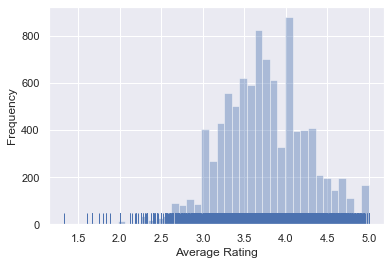

In [35]:
sns.distplot(mean_ur['rating'], kde=False, rug=True, bins=40);
plt.ylabel('Frequency')
plt.xlabel('Average Rating')

From the above plot we can see that most of the user ratings are towards 3.5 and above. There are very few ratings in the range of 1-3.

### Books Data

We further explore the training dataset to gain better understanding of the features in the dataset and their relationships

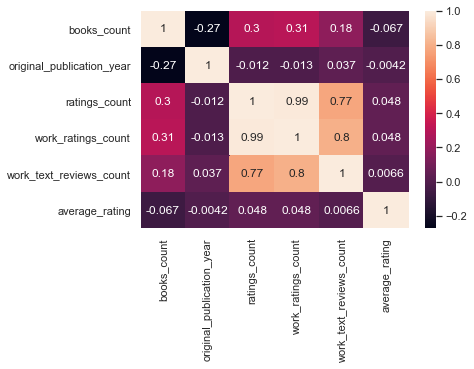

In [36]:
# plot a correlation matrix to show the relationship between numerical features
corrMatrix = df_train[['books_count','original_publication_year','ratings_count','work_ratings_count','work_text_reviews_count','average_rating']].corr()
sns.heatmap(corrMatrix, annot=True)
plt.show()

The correlation heatmap above shows the correlation between different variables included in the dataset. Count of ratings of a book denoted by 'ratings count' and count of ratings of all editions of a book denoted by 'work_ratings_count' and 'work_text_reviews_count' are strongly correlated which may lead to multicollinearity in the model, hence we will keep only one of these three variables.

In [37]:
# define functions to make plots
def plot_scatter(df, x_label, y_label, chart_title):
    cmap = sns.cubehelix_palette(dark=.3, light=.8, as_cmap=True)
    sns.scatterplot(x=x_label, y=y_label, data=df, palette=cmap)
    plt.title(chart_title)
    
def plot_scatter_and_trendline(x, y, chart_title):
    sns.regplot(x,y)
    plt.title(chart_title)

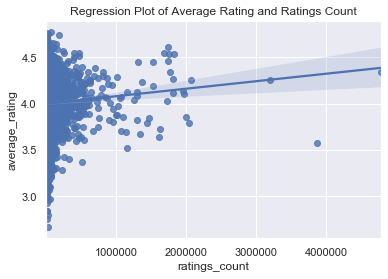

In [38]:
# make a regression plot of average rating and ratings count
plot_scatter_and_trendline(df_train['ratings_count'], df_train['average_rating'], 'Regression Plot of Average Rating and Ratings Count')

From the above graph we can see that books with a higher count of ratings (reviews) tend to have better ratings.

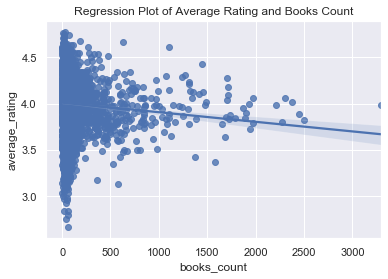

In [39]:
# make a regression plot of average rating and books count
plot_scatter_and_trendline(df_train['books_count'], df_train['average_rating'], 'Regression Plot of Average Rating and Books Count')

The average rating of a book seems to decline as the number of its copies increases.

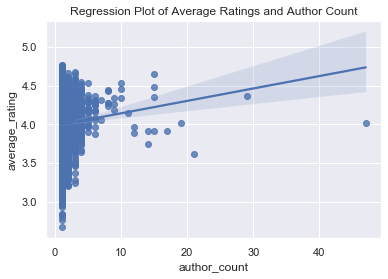

In [40]:
# make a regression plot of average rating and Authors count
plot_scatter_and_trendline(df_train['author_count'], df_train['average_rating'], 'Regression Plot of Average Ratings and Author Count')

The average ratings of books written by multiple authors seems to be higher than those written by single authors.

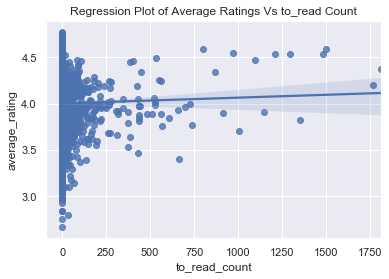

In [41]:
# make a regression plot of average rating and to_read count
df_train['to_read_count']= df_train['to_read_count'].astype(int)
plot_scatter_and_trendline(df_train['to_read_count'], df_train['average_rating'], 'Regression Plot of Average Ratings Vs to_read Count')

Books with higher ratings seem to have been marked as 'to_read' by users higher number of times.

Text(0.5, 1.0, 'Bar Plot of Cleaned tags and Average Ratings')

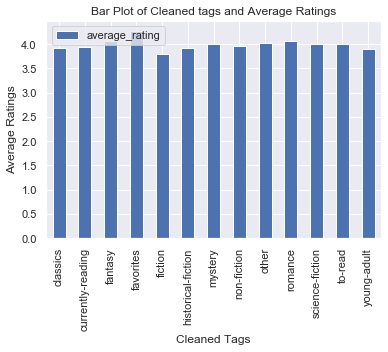

In [42]:
df_train.groupby('tag_cleaned').mean()[['average_rating']].plot(kind='bar')
plt.xlabel('Cleaned Tags')
plt.ylabel('Average Ratings')
plt.title('Bar Plot of Cleaned tags and Average Ratings')

In [43]:
folder_path = "../data/processed/"

df_train_out = open(folder_path + "df_train", 'wb')
pickle.dump(df_train, df_train_out)
df_train_out.close()

df_test_out = open(folder_path + "df_test", 'wb')
pickle.dump(df_test, df_test_out)
df_test_out.close()

target_out = open(folder_path + "target", 'wb')
pickle.dump(target, target_out)
target_out.close()